# Three-dimensional lidar data classification of complex natural scenes with multi-scale features

Made by Leonard Seydoux in May 2023

## 1. Introduction

This notebook is part of the [_Réseau Numérique en Terre Solide_](https://nuts.univ-nantes.io/) (NuTS), a CNRS thematic network (RT) that aims to foster the community of developers and users of numerical tools for solid earth science. Our goal is to make this community more visible, efficient, and informed through a series of conferences and training courses on digital science, from data manipulation to intensive scientific computing.

This notebook was adapted from the course [_Earth Data Science_](https://pss-gitlab.math.univ-paris-diderot.fr/dralucas/earth-data-science) taught at the [institut de physique du globe de Paris](https://www.ipgp.fr/) and led by Antoine Lucas and Léonard Seydoux. 

The goal of this session is to classify a three-dimensional point cloud acquired by a lidar sensor. The point cloud was aquired in a forest and contains points belonging to path, grass, trees and walls, as shown with a density colormap below. We will identify a way to define relevant features for the classification, train a classifier, and evaluate its performance. Finally, we will try to improve the classification by using a more advanced strategies.

![](./images/scene.png)

> This lidar scene was captured by Antoine Lucas in the forest of Fontainebleau, France. The point cloud contains 4 classes: paths, grass, trees and walls. This image was rendered with the online open-source project [plas.io](https://plas.io/).


The feature extraction presented here is based on the paper by Brodu and Lague ([2012](https://www.sciencedirect.com/science/article/abs/pii/S0924271612000330)). The main idea is to exploit the spatial distribution of the points in a three-dimensional sphere at various spatial scales to make a difference between the different classes. The notebook uses the module `lidar` that is a wrapper of the `laspy` library to deal with lidar data. For more information about the functions and usage, please refer to the `lidar` module docstrings, and the [laspy documentation](https://laspy.readthedocs.io/en/latest/).

### 1.1. Module import

Let's first make sure that your environment is properly set up by importing the required modules. If you encounter any error, please let us know as soon as possible so we can provide you with help.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import lidar

### 1.2. Figure settings

The next command lines allow to define some properties for the matplotlib figures. By default, the `inline` figures are not interactive and displayed in raster format (e.g., PNG). Turning this to SVG format allow to have vector graphics, which does not suffer from resolution issues. In order to guarantee that the graphics are not too heavy, we will use the `rasterized` option for large plots (e.g., the three-dimensional point cloud) in the notebook. You can read more about the matplotlib rasterization in the [matplotlib documentation on raster and vector plots](https://matplotlib.org/stable/gallery/misc/rasterization_demo.html). Note that generally speaking, for vector outputs like PDF, it may be useful to turn the rasterization on for large-scale layers. The resolution of the rasterization is specied by the `dpi` parameter.

## 2. Data loading and visualization

### 2.1. The entire scene (unlabeled)

The entire scene contains several classes: path, trees, walls, and grass that are unlabeled. First, we can load the data and plot the points in a three-dimensional plot. We can have a look at it from different angles to get a better understanding of the scene. The current notebook uses the inline plotting of matplotlib, which does not provide interaction. For changing angles, you therefore need to rerun the cell with the `ax.view_init` command. If you prefer to use an interactive plot, you can use the `%matplotlib widget` magic command. Note that there is a big slowdown when using the interactive plot.

The entire scene contains more than 18 million points. This is too much to be displayed in a single plot in matplotlib. Other plotting library may handle such a number of points better. We can use the `lidar` module to load the data and plot a subset of the points. After reading the entire scene with the `lidar.read_las` function, you can use the `lidar.show_scene` function to show the scene. Note that the `show_scene` function takes a `n_points` parameter that allows to specify the number of points to display (randomly sampled). This is useful to speed up the plotting and to get a better understanding of the scene.

> __Note__: The number of points `n_points`, point size `s` and transparency `alpha` are parameters that can be tuned to get a better visualization of the scene. These values were calibrated on a different computer, so you may need to adjust them to get a better visualization.

Total number of points in scene: 1,314,642


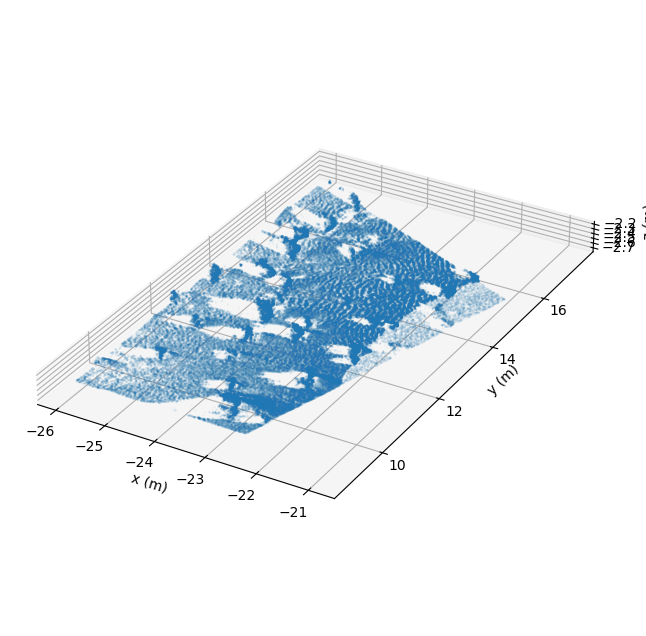

In [2]:
# Read the whole dataset
scene = lidar.read_xyz("data/evaluation/scene2.xyz")

# Get the shape of the dataset
print(f"Total number of points in scene: {scene.shape[0]:,}")

# Create figure and axes
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")

# Plot the scene
lidar.plot_scene(scene, s=0.1, alpha=0.1, n_points=250000, ax=ax)

# Show
plt.show()

### 2.2. The labeled sets

The four classes of objects have been identified manually in a subset of the data. These classes are located in the `data/labeled` folder. We can display them on the same plot to maje a difference between all scenes. Because these are extracted from the main dataset manually (by selecting rectangular subsets of the original dataset), we can actually speak about a classification problem (supervised), but another more accurate term would be a semi-supervised learning problem, where only a subset of the data is labeled.

Dataset from file ./data/train/floor.xyz contains 40,069 points
Dataset from file ./data/train/vegetation.xyz contains 4,608 points


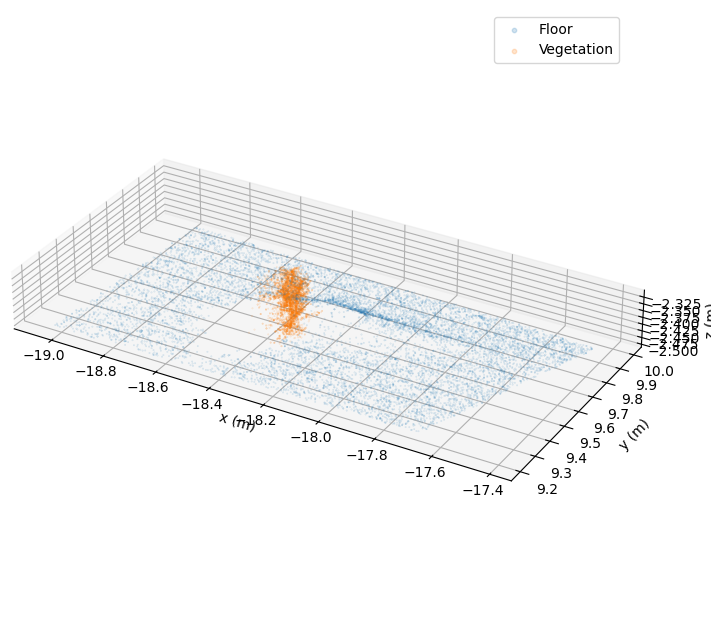

In [3]:
# Select the number of points to show from every category
n_display_points = 10000

# Create figure and axes to plot every subset on
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")

# Get paths to all the files in the folder
filepaths = sorted(glob.glob("./data/train/*.xyz"))

# Iterate over the files in the folder
for filepath in filepaths:

    # Read the whole dataset
    # dataset = lidar.read_las(filepath)
    dataset = lidar.read_xyz(filepath)
    category = os.path.basename(filepath).replace(".xyz", "")

    # Get info
    print(f"Dataset from file {filepath} contains {dataset.shape[0]:,} points")

    # Plot a subsample of the dataset
    lidar.plot_scene(
        dataset,
        n_points=n_display_points,
        s=0.1,
        alpha=0.2,
        ax=ax,
        label=category.title(),
    )

# Labels
ax.legend(markerscale=10)
plt.show()

## 3. Feature extraction

In order to classify the points, we need to extract features from the point cloud. The features should be relevant to make a difference between the different classes. The features should also be invariant to the position of the points in the scene. For example, the height of the points is not a good feature because it depends on the position of the sensor. The features should also be invariant to the number of points in the scene. For example, the number of points in a given area is not a good feature because it depends on the distance between the sensor and the objects.

### 3.1. Local dimensionality at given scale

#### Neighborhood ball

Following Brodu and Lague ([2012](https://www.sciencedirect.com/science/article/abs/pii/S0924271612000330)), an idea is to characterize the local dimensionality for each points of the cloud at different scales $d$. In other terms, considering a __neighborhood ball__ of diameter $d$ and center point $c = (x_c, y_c, z_c)$ called __scene point__, are the set of __neighbor points__ within this ball located on a line, a plane, or a volume? 

<figure style="margin: 50px">
    <img src="images/neighborhood_ball.png" width="700">
    <figcaption><b>Fig. 1: </b>Illustration from Brodu and Lague (2012) showing the neighborhood ball with various diameters, the scene point and neighbor points.</figcaption>
</figure>

#### Principal component analysis

To answer this question, we can use the principal component analysis (PCA) to find the directions of maximum variance of the point cloud within a sphere. If the data varies mostly along a line, the variance in this direction will be much larger than the variance in the other directions, and therefore only one eigenvalue will be much larger than the others. If the data varies mostly along a plane, the variance in this plane will be much larger than the variance in the other directions, and therefore two eigenvalues will be much larger than the third one. Finally, if the data varies mostly in a volume, the variance in all directions will be similar, and therefore the three eigenvalues will be similar.

We can formally write this problem by considering a set of $n$ points $\mathbf{r} = \{\mathbf{r}_i\}_{i=1}^n$, with $\mathbf{r}_i = (x_i, y_i, z_i)$, located in a sphere of diameter $d$ and center point $\mathbf{r}_c = (x_c, y_c, z_c)$. The covariance matrix $\mathbf{C}$ of the points in the sphere is defined as:

$$
\mathbf{C} = \frac{1}{n} \sum_{i=1}^n (\mathbf{r}_i - \mathbf{r}_c) (\mathbf{r}_i - \mathbf{r}_c)^T.
$$

The covariance matrix is symmetric and positive semi-definite, so that it can be diagonalized as:

$$
\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T,
$$

where $\mathbf{U}$ is the matrix of eigenvectors and $\mathbf{\Lambda}$ is the diagonal matrix of eigenvalues. The eigenvectors are orthogonal and normalized, so that $\mathbf{U}^T \mathbf{U} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix. The diagonal matrix of eigenvalues $\mathbf{\Lambda}$ is defined as:

$$
\mathbf{\Lambda}= 
\begin{bmatrix}
\lambda_1 & 0 & 0 \\
0 & \lambda_2 & 0 \\
0 & 0 & \lambda_3
\end{bmatrix},
$$

where $\lambda_1 \geq \lambda_2 \geq \lambda_3 \geq 0$. We normalize the eigenvalues by the sum of all eigenvalues to make them invariant to the number of points in the sphere. The eigenvalues of the covariance matrix of the points in the sphere can be used to characterize the local dimensionality, as illustrated in the figure below.

<figure style="margin: 50px; width: 550px">
<img src="images/eigenvalues.png">
<figcaption><b>Fig. 2: </b>Illustration of the expected eigenvalues of the covariance matrix of the points in the sphere for different geometries.</figcaption>
</figure>

The eigenvalues are sorted in decreasing order, so that $\lambda_1$ is the largest eigenvalue and $\lambda_3$ is the smallest. The eigenvalues are normalized by the sum of all eigenvalues to make them invariant to the number of points in the sphere. The goal of this exercice is to define an algorithm that allow to extract the __neightboring points__ of all points in the cloud, compute the __eigenvalues of the covariance matrix__ of these points at different scales, and later use these eigenvalues as __features__ for the classification.

#### Core points

In order to avoid computing the covariance and eigenvalues for all points in the cloud, we will first identify a subset of points called __core points__ that will be used to compute the features. The core points are defined as points with a sufficient number of neighbors within a given diameter $d$, and are initially sampled randomly.

> Also note that for some scales, the point cloud may be empty. In this case, the eigenvalues are set to NaNs and will be ignored in the classification. Actually, for robustness, we will systematically reject the points with a number of neighbors below a given threshold set by the `n_min_points` parameter.

In [4]:
N_CORE_POINTS = 10000
N_MIN_POINTS = 10
DIAMETER = 0.1

# Load the dataset
points = lidar.read_xyz("./data/train/vegetation.xyz")

# Consider a subset of the dataset (e.g., core points) to extract features from
core_points = lidar.sample(points, N_CORE_POINTS)

# Calculate eigenvalues
eigenvalues = lidar.calculate_eigenvalues(core_points, points, DIAMETER, N_MIN_POINTS)

# Info
print(f"Number of core points: {len(eigenvalues):,}")
print(f"Number of outliers: {np.isnan(eigenvalues).any(axis=1).sum():,}")

Number of core points: 4,608
Number of outliers: 1


### 3.2. Natural representation of the eigenvalues

Any covariance matrix $\mathbf{C} \in \mathbb{R}^{3 \times 3}$ delivers eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ such as $\lambda_1 \geq \lambda_2 \geq \lambda_3 \geq 0$ because the covariance matrix is symmetric and positive semi-definite. Without normalization, the three eigenvalues are not invariant to the number of points in the sphere, and can take any arbitrary value. To make the eigenvalues invariant to the number of points in the sphere, we can normalize them by the sum of all eigenvalues. This way, the sum of the eigenvalues is always equal to 1.

<figure style="margin: 50px; width: 550px">
<img src="images/eigentriangle.png">
<figcaption><b>Fig. 3: </b>Expected behaviour of the eigenvalues.</figcaption>
</figure>

Once normalized, the eigenvalues all fall in the triangular region delimited represented in the the figure above, and in the shaded area from the cell's plot below. Note that we used a colorscale for the third eigenvalue $\lambda_3$.

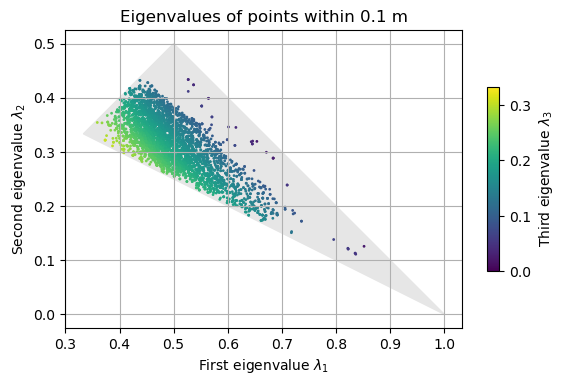

In [5]:
# Extract eigenvalues
l1, l2, l3 = eigenvalues.T

# Plot
fig, ax = plt.subplots()
mappable = ax.scatter(l1, l2, c=l3, s=1, rasterized=True, vmin=0, vmax=1 / 3)

# Labels
cb = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=15)
cb.set_label("Third eigenvalue $\lambda_3$")
ax.set_xlabel("First eigenvalue $\lambda_1$")
ax.set_ylabel("Second eigenvalue $\lambda_2$")
ax.set_title(f"Eigenvalues of points within {DIAMETER} m")
ax.set_aspect("equal")
ax.grid()

# Add eigenvalue triangle patch for reference
triangle_summits = [(1 / 3, 1 / 3), (0.5, 0.5), (1, 0)]
triangle = plt.Polygon(triangle_summits, color="0.9", zorder=-1)
ax.add_patch(triangle)

# Show
plt.show()

### 3.3. Ternary representation of the eigenvalues

Because of the normalization, the eigenvalues are always positive and sum to 1. Therefore, only two eigenvalues are necessary to represent the three eigenvalues. In other words, they can be represented as a point in a 2D plane, using the barycentric coordinates. For more information about the barycentric coordinates, you can read the [Wikipedia page](https://en.wikipedia.org/wiki/Barycentric_coordinate_system). We provide you here with a function to convert the eigenvalues to barycentric coordinates called `lidar.calculate_barycentric_coordinates`. The function takes as input the three eigenvalues and returns the barycentric coordinates.

The colormap of the ternary plot depends on the local density of the points calculated with a Gaussian kernel density estimation (KDE). The KDE is computed with the `scipy.stats.gaussian_kde` function.

> For walls, at a scale of 5 meters, you realize that the point cloud is mostly two-dimensional, as expected. You can take time to play with different scales and datasets to see how the ternary plot changes.

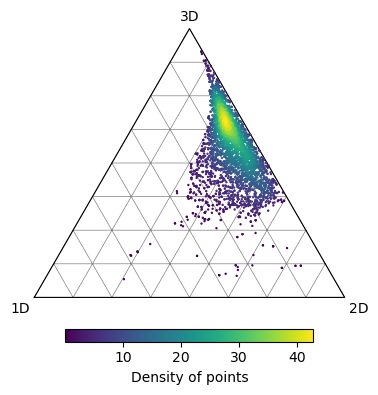

In [6]:
# Ternary plot of the eigenvalues
barycenters = lidar.calculate_barycentric_coordinates(eigenvalues)
lidar.plot_ternary(*barycenters)

# Show
plt.show()

### 3.3. Multi-scale feature extraction

Now, we can extract the barycentric coordinates of all points in the cloud at different scales. For each scale $d$, we obtain a set of barycentric coordinates $(x_d, y_d)$ where $x_d$ and $y_d$ are the barycentric coordinates of the core points. We will define the features as the concatenation of all barycentric coordinates at different scales. In other words, the features are defined as:

$$
\mathbf{f} = \left[ x_1, y_1, x_2, y_2, \dots, x_D, y_D \right] \in \mathbb{R}^{2D}
$$

where $D$ is the number of scales. The number of scales $D$ is a parameter that can be tuned to get a better classification. These values were calibrated on a different computer, so you may need to adjust them to get a better classification.

> Let's first collect the features from a given dataset and see how they look like for different scales. You can then play with the different datasets and scales to see how the features change.

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


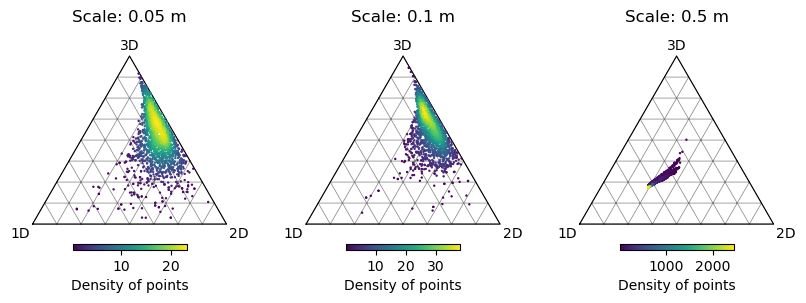

In [7]:
SCALES_IN_M = 0.05, 0.1, 0.5
N_CORE_POINTS = 2000
N_MIN_POINTS = 10

# Calculate features
points = lidar.read_xyz("./data/train/vegetation.xyz")
core_points = lidar.sample(points, N_CORE_POINTS)
features = []

for scale in tqdm.tqdm(SCALES_IN_M):

    # Calculate eigenvalues (in parallel)
    eigenvalues = lidar.calculate_eigenvalues(core_points, points, scale, N_MIN_POINTS)

    # Calculate tertiary coordinates
    features.append(lidar.calculate_barycentric_coordinates(eigenvalues))

# Show all ternary plots
fig, axes = plt.subplots(1, len(SCALES_IN_M), figsize=(10, 3))
for ax, feature, scale in zip(axes, features, SCALES_IN_M):

    # Plot
    lidar.plot_ternary(*feature, ax=ax)
    ax.set_title(f"Scale: {scale} m\n")

### 3.4. Build the database

We now need to extract the features for all datasets at different scales. We will store the features in a database that will be used later for the classification. You can save the feature in a file in order to avoid recomputing them each time you run the notebook.

In [8]:
FILEPATH_TRAINING = "data/train/*.xyz"
N_CORE_POINTS = 4000
N_MIN_POINTS = 10

# Create empty list of features
scale_x_features = [f"scale_{scale}_x" for scale in SCALES_IN_M]
scale_y_features = [f"scale_{scale}_y" for scale in SCALES_IN_M]

# Feature dataframe
features = pd.DataFrame(columns=scale_x_features + scale_y_features + ["category"])

for training_file in glob.glob(FILEPATH_TRAINING):
    
    # Get category
    category = os.path.basename(training_file).replace(".xyz", "")

    # Read the dataset
    dataset = lidar.read_xyz(training_file)
    core = lidar.sample(dataset, N_CORE_POINTS)
    dataset_features = pd.DataFrame(columns=features.columns)

    for scale in tqdm.tqdm(SCALES_IN_M, desc=f"Processing {training_file}"):

        # Calculate eigenvalues (in parallel)
        eigenvalues = lidar.calculate_eigenvalues(core, dataset, scale, N_MIN_POINTS)
        
        # Calculate tertiary coordinates
        x, y = lidar.calculate_barycentric_coordinates(eigenvalues)

        # Add to the dataframe
        dataset_features[f"scale_{scale}_x"] = x
        dataset_features[f"scale_{scale}_y"] = y
        dataset_features["category"] = category    

    # Turn into a dataframe
    features = pd.concat([features, dataset_features])

# Reset index
features = features.reset_index(drop=True)

Processing data/train/vegetation.xyz: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
/var/folders/vb/xqq7d5zj58l1hwcqvtq16zf00000gn/T/ipykernel_47559/3536186769.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features, dataset_features])
Processing data/train/floor.xyz:   0%|          | 0/3 [00:00<?, ?it/s]

## 4. Classification (training and testing)

Now that we have extracted the features, we can use them to train a classifier. We will compare the performance of different classifiers, as we did in the previous notebook. We will use the same classifiers as in the previous notebook on the IRIS dataset, but we will use the features extracted from the point cloud instead of the features extracted from the flowers.

### 4.1. Split the dataset into a training set and a test set 

In order to train a classifier correctly, we need to split the dataset into a training set and a test set. The training set will be used to train the classifier, and the test set will be used to evaluate the performance of the classifier. We will use the `train_test_split` function from scikit-learn to split the dataset into a training set and a test set. We will use 80% of the dataset for training and 20% for testing. The next cell uses the data in a dataframe format, so the classifier will remember the name of the features. If you would like to avoid this, you can use the `values` attribute of the dataframe to get a numpy array.

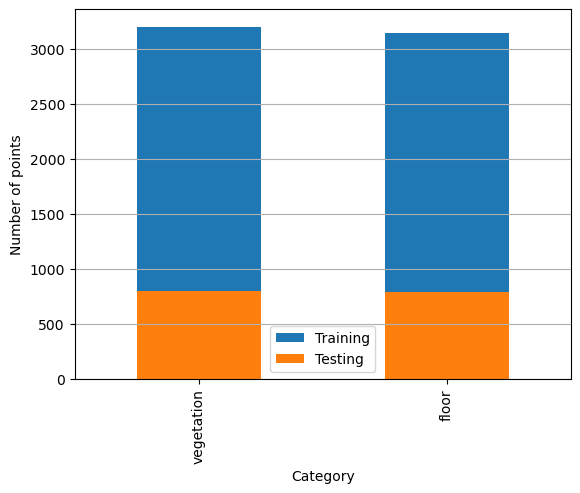

In [ ]:
from sklearn.model_selection import train_test_split

# Remove rows with NaN values
features_clean = features.dropna()

# Split features and labels
x = features_clean.drop({"category"}, axis=1)
y = features_clean["category"].copy()

# Split data randomly into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot the training and test labels distribution with bars of different colors
fig, ax = plt.subplots()
y_train.value_counts().plot.bar(ax=ax, label="Training", color="C0")
y_test.value_counts().plot.bar(ax=ax, label="Testing", color="C1")

# Labels
ax.set_ylabel("Number of points")
ax.set_xlabel("Category")
ax.grid(axis="y")
ax.legend()

# Show
plt.show()

### 4.2. Train the classifier

As in the previous case, we will import and create an instance of the classifier, and then train it with the training set using the `fit` method. We will then use the classifier to predict the labels of the test set using the `predict` method. Finally, we will evaluate the performance of the classifier using the various metrics provided by scikit-learn.

In [ ]:
from sklearn.svm import SVC

# Instantiate the model
model = SVC()

# Fit the model
model.fit(x_train, y_train)

# Training score
print(f"Training score: {model.score(x_train, y_train):.2%}")

Training score: 100.00%


### 4.3. Test error and confusion matrix

We will now compute the test error and the confusion matrix. The test error is the fraction of points that are misclassified. The confusion matrix is a matrix that shows the number of points that are classified as a given class. The diagonal of the confusion matrix shows the number of points that are correctly classified. The confusion matrix is computed with the `ConfusionMatrixDisplay` class from scikit-learn.

Accuracy on the train data: 100.00%
Accuracy on the test data: 100.00%
Overall accuracy: 100.00%


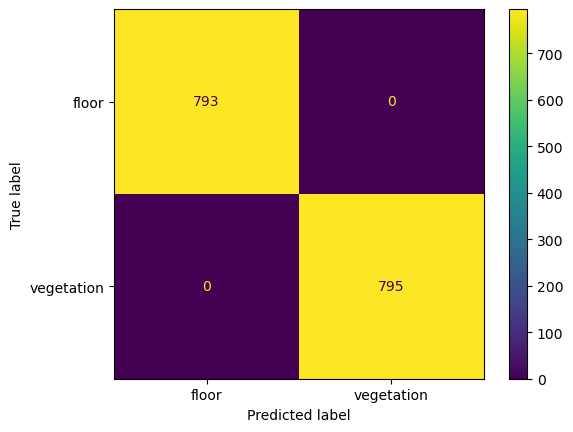

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predict the test data
y_test_pred = model.predict(x_test)
category_names = model.classes_

# Show confusion matrix on the predicted test data
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=category_names)

# Accuracies
score_train = model.score(x_train, y_train)
score_test = model.score(x_test, y_test)
score = model.score(x, y)

print(f"Accuracy on the train data: {score_train:.2%}")
print(f"Accuracy on the test data: {score_test:.2%}")
print(f"Overall accuracy: {score:.2%}")

## 5. Evaluation on the entire dataset

This is obviously the most important part, or at least the main objective of the project. You will need to apply the classifier to the entire dataset and visualize the results. Of course, there are many things that you can improve by playing around with the different parameters such as the scales, the dataset size, and so. 

### 5.1. Feature extraction

First, we need to extract __the same features__ as in the training phase on the labeled dataset. We will use the same scales. We will then use the classifier to predict the labels of the points in the dataset.

In [ ]:
# Read again the entire dataset
dataset = lidar.read_xyz("./data/evaluation/scene.xyz")

# Core points
core_points = dataset[::50]
print(f"Number of core points: {len(core_points)}")

# Read pickle file features
# Create empty list of features
scale_x_features = [f"scale_{scale}_x" for scale in SCALES_IN_M]
scale_y_features = [f"scale_{scale}_y" for scale in SCALES_IN_M]

# Feature dataframe
dataset_features = pd.DataFrame(columns=scale_x_features + scale_y_features)
for scale in tqdm.tqdm(SCALES_IN_M, desc=f"Processing {training_file}"):\

    # Calculate eigenvalues (in parallel)
    eigenvalues = lidar.calculate_eigenvalues(core_points, dataset, scale, N_MIN_POINTS)
    
    # Calculate tertiary coordinates
    x, y = lidar.calculate_barycentric_coordinates(eigenvalues)

    # Add to the dataframe
    dataset_features[f"scale_{scale}_x"] = x
    dataset_features[f"scale_{scale}_y"] = y

# Reset index
dataset_features = dataset_features.reset_index(drop=True)

Number of core points: 38166


Processing data/train/floor.xyz:   0%|          | 0/3 [00:00<?, ?it/s]

0.05


Processing data/train/floor.xyz:  33%|███▎      | 1/3 [00:11<00:22, 11.19s/it]

[0.53960472 0.61252059 0.52363017 ... 0.86196347 0.58896903 0.7427022 ] [0.02046973 0.00846549 0.33234917 ... 0.13934841 0.26243732 0.4272404 ]
0.1


Processing data/train/floor.xyz:  67%|██████▋   | 2/3 [00:22<00:11, 11.38s/it]

[0.53295376 0.8047279  0.56010205 ... 0.64842856 0.54500419 0.76477222] [0.00739524 0.00411227 0.36974361 ... 0.34706453 0.46324066 0.19712376]
0.5


Processing data/train/floor.xyz: 100%|██████████| 3/3 [00:35<00:00, 11.87s/it]

[0.53539724 0.9363863  0.69050205 ... 0.75832984 0.49624811 0.75160549] [8.65654275e-04 4.21555730e-04 4.46544801e-01 ... 1.76705778e-01
 2.70610724e-01 2.17071697e-01]


In [ ]:
dataset_features

,scale_0.05_x,scale_0.1_x,scale_0.5_x,scale_0.05_y,scale_0.1_y,scale_0.5_y
0,0.539605,0.532954,0.535397,0.020470,0.007395,0.000866
1,0.612521,0.804728,0.936386,0.008465,0.004112,0.000422
2,0.523630,0.560102,0.690502,0.332349,0.369744,0.446545
3,0.850873,0.732054,0.943704,0.012428,0.005735,0.000732
4,0.617419,0.609210,0.706575,0.502813,0.650233,0.470995
...,...,...,...,...,...,...
38161,0.598123,0.701093,0.716828,0.196856,0.322760,0.361628
38162,NaN,0.591126,0.730471,NaN,0.530278,0.362735
38163,0.861963,0.648429,0.758330,0.139348,0.347065,0.176706
38164,0.588969,0.545004,0.496248,0.262437,0.463241,0.270611


### 5.2. Prediction

Now we can use the classifier to predict the labels of the points in the dataset. We will use the `predict` method of the classifier to predict the labels of the points in the dataset. Now it's the visualization part!

In [ ]:
# Predict
unknown_features_clean = dataset_features.dropna()
core_points = core_points[unknown_features_clean.index]
y_pred = model.predict(unknown_features_clean)

# Transform strings to integers
category_names = model.classes_.tolist()
y_pred = np.array([category_names.index(category) for category in y_pred])


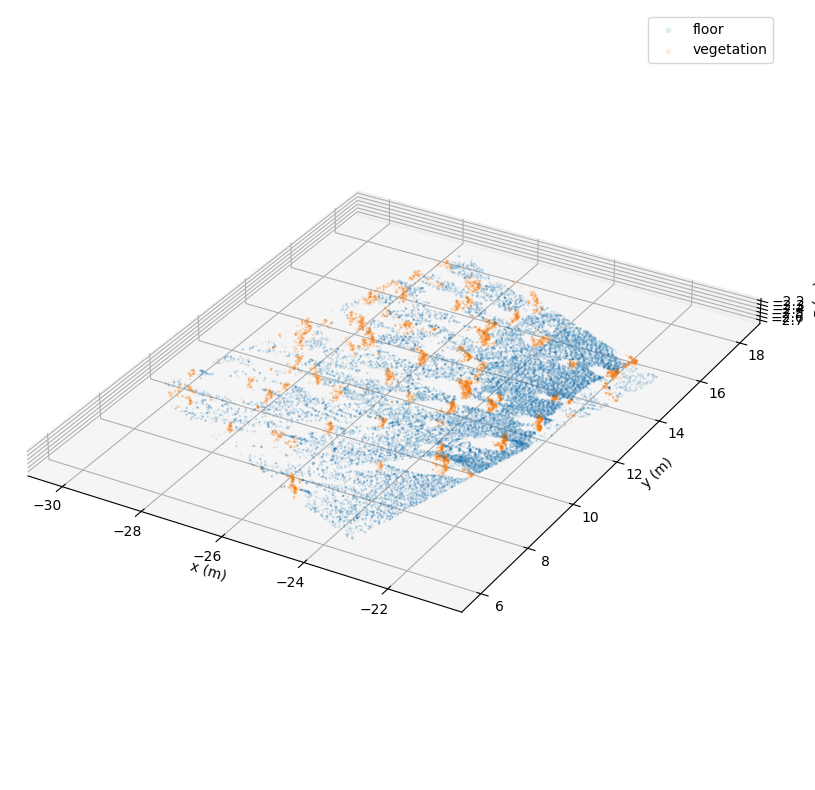

In [ ]:
# Plot
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10, 10))
for y_class in np.unique(y_pred):

    # Get points from the same class
    points_within_class = core_points[y_pred == y_class]

    # Plot
    lidar.plot_scene(
        points_within_class,
        s=0.4,
        alpha=0.1,
        n_points=40000,
        ax=ax,
        c=f"C{y_class}",
        label=category_names[y_class],
    )

# Labels
ax.legend(markerscale=5)
plt.show()


## 6. Bonus: clustering

OK, now that we obtained some results, we can try also another approach: clustering. We will use the same features as in the classification part, but we will use a clustering algorithm instead of a classifier. This may allow us to discover some new classes that we did not know about, or that we did not label. 

Similarly than for classification, clustering algorithms are available in scikit-learn, and you can find various algorithms in the [clustering section](https://scikit-learn.org/stable/modules/clustering.html) of the scikit-learn documentation. You can also find a [tutorial on clustering](https://scikit-learn.org/stable/modules/clustering.html) in the scikit-learn documentation.

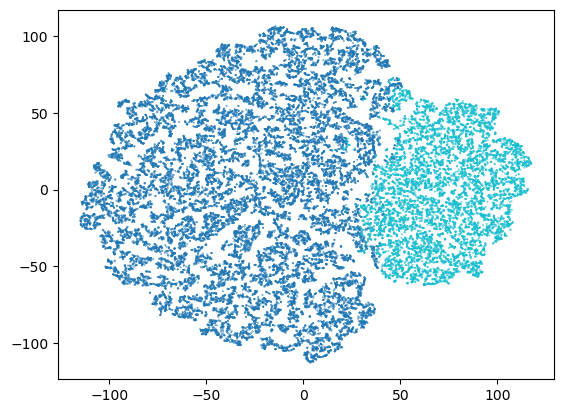

In [ ]:
x = dataset_features.dropna().to_numpy()
# y_pred = model.predict(x)
from sklearn.manifold import TSNE

# Instantiate the model
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1)

# Fit the model
x_tsne = tsne.fit_transform(x)

# Plot
fig, ax = plt.subplots()
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], s=0.1, c=y_pred, cmap="tab10", rasterized=True)

<center><img src="https://s3.glicid.fr/nuts/workshop-footer.svg"/></center>